# Modelling: Random Forest Classifier

Notebook ini melatih model Random Forest untuk memprediksi tingkat kesejahteraan.

**Langkah-langkah:**
1. Memuat data hasil preprocessing.
2. Split data (Training & Testing).
3. Encoding & Scaling.
4. Training Model.
5. Evaluasi & Visualisasi.
6. Menyimpan Model.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Konfigurasi Visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Konfigurasi Path
DATA_PATH = '../preprocessing/dataset_preprocessed.csv'
MODEL_PATH = 'rf_model_kesejahteraan.pkl'
METRICS_PATH = 'metrics.json'

## 1. Persiapan Data

In [10]:
def load_and_split_data(path):
    """Memuat data, encoding target, dan split training/testing."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset tidak ditemukan di: {path}")
    
    df = pd.read_csv(path)
    print(f"Data dimuat: {df.shape}")
    
    X = df.drop('kesejahteraan', axis=1)
    y_raw = df['kesejahteraan']
    
    # Encoding Target
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    
    # Simpan mapping
    label_mapping = {int(i): label for i, label in enumerate(le.classes_)}
    print("Label Mapping:", label_mapping)
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test, le, label_mapping, X.columns

## 2. Training Model

In [11]:
def train_model(X_train, y_train):
    """Scaling fitur dan training Random Forest."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_scaled, y_train)
    
    return rf_model, scaler, X_train_scaled

## 3. Eksekusi Training

In [12]:
# Load & Split
X_train, X_test, y_train, y_test, le, mapping, feature_names = load_and_split_data(DATA_PATH)

# Train
model, scaler, _ = train_model(X_train, y_train)
print("Training selesai.")

Data dimuat: (405, 5)
Label Mapping: {0: 'Cukup', 1: 'Sangat Sejahtera', 2: 'Sangat Tidak Sejahtera', 3: 'Sejahtera', 4: 'Tidak Sejahtera'}
Training selesai.


## 4. Evaluasi & Visualisasi

In [13]:
# Prepare Test Data
X_test_scaled = scaler.transform(X_test)

# Predict
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"Akurasi Model: {acc:.4f}")

if acc < 0.75:
    print("⚠️ Akurasi di bawah target 0.75")
else:
    print("✅ Akurasi memenuhi target (> 0.75)")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Akurasi Model: 0.9383
✅ Akurasi memenuhi target (> 0.75)

Classification Report:
                        precision    recall  f1-score   support

                 Cukup       0.83      1.00      0.91        10
      Sangat Sejahtera       1.00      1.00      1.00        24
Sangat Tidak Sejahtera       1.00      0.89      0.94        27
             Sejahtera       1.00      0.67      0.80         3
       Tidak Sejahtera       0.84      0.94      0.89        17

              accuracy                           0.94        81
             macro avg       0.94      0.90      0.91        81
          weighted avg       0.95      0.94      0.94        81



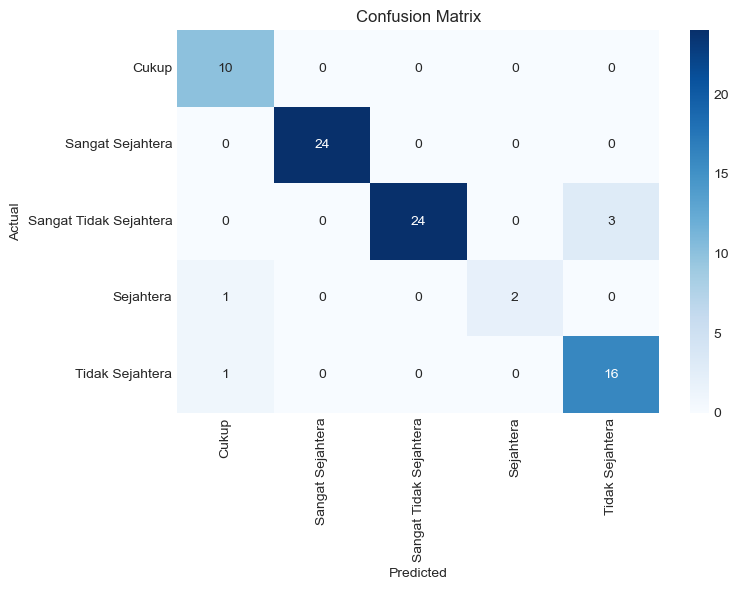

In [14]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

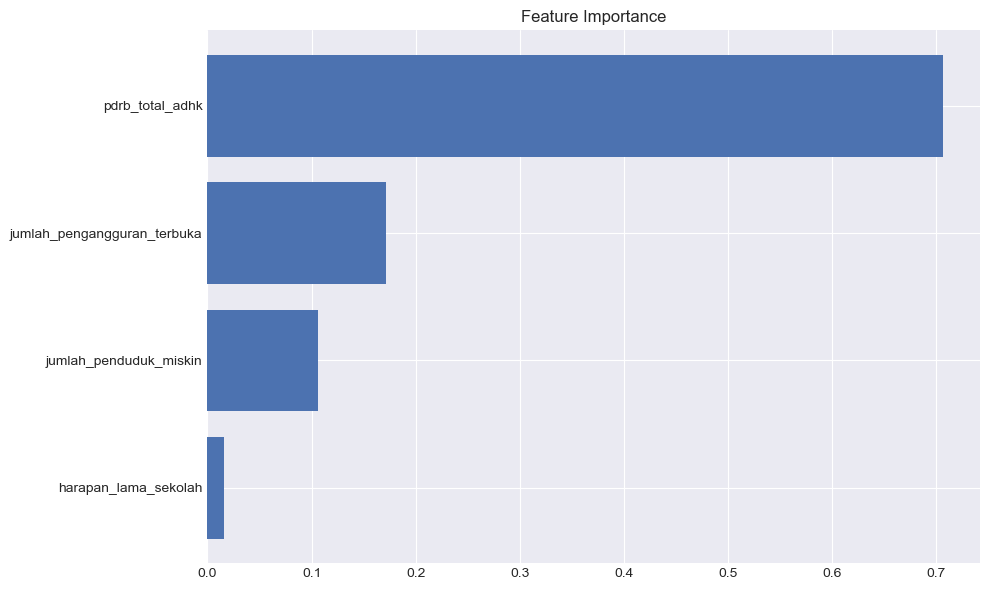

In [15]:
# 2. Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], align="center", color='#4c72b0')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

## 5. save Model

In [16]:
artifacts = {
    'model': model,
    'scaler': scaler,
    'mapping': mapping,
    'features': list(feature_names)
}

joblib.dump(artifacts, MODEL_PATH)
print(f"Model tersimpan di: {os.path.abspath(MODEL_PATH)}")

# Simpan metrics
metrics = {
    'accuracy': acc,
    'classification_report': classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
}
with open(METRICS_PATH, 'w') as f:
    json.dump(metrics, f, indent=4)

Model tersimpan di: /media/boba/DATA/STT Wastukancana/SEMESTER 5/MACHINE LEARNINGGGGG/TUGAS/UAS/prediksi_kesejahteraan/modelling/rf_model_kesejahteraan.pkl
